<a href="https://colab.research.google.com/github/harim4422/tensorflow2_deeplearning/blob/master/reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

!apt-get update
!apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym[atari]

!pip install box2d-py
!pip install gym[Box_2D]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,682 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 1,280 kB in 3s (483 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144542 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import gym
import random

TensorFlow 2.x selected.


In [3]:
# env.render() 함수의 결과를 mp4 동영상으로 보여주기 위한 코드
# from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env
  
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
env = gym.make('MountainCar-v0')

In [0]:
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)
print(env.action_space)
print(env._max_episode_steps)

Box(2,)
[-1.2  -0.07]
[0.6  0.07]
Discrete(3)
200


In [0]:
env = wrap_env(env)
step = 0
score = 0
env.reset()

while True:
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  score += reward
  step += 1
  if done:
    break
  
env.close()
show_video()
print('Final Score : ', score)
print('Step : ', step)

Final Score :  -200.0
Step :  200


In [4]:
import numpy as np

env = gym.make('MountainCar-v0')

scores = []
training_data = []
accepted_scores = []
required_score = -198
for i in range(20000):
  env.reset()
  score = 0
  game_memory = []
  previous_obs = []

  while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if len(previous_obs) > 0:
      game_memory.append([previous_obs, action])
    previous_obs = obs
    if obs[0] > -0.2:
      reward = 1
    score += reward
    if done:
      break
  
  scores.append(score)
  if score > required_score:
    accepted_scores.append(score)
    for data in game_memory:
      training_data.append(data)
print('finished!')

finished!


In [5]:
print('mean of scores', np.mean(scores))
print('length of acceted_scores', len(accepted_scores))
print('mean of acceted_scores', np.mean(accepted_scores))

mean of scores -199.9036
length of acceted_scores 100
mean of acceted_scores -180.74


In [6]:
train_X = np.array([i[0] for i in training_data]).reshape(-1, 2)
train_Y = np.array([i[1] for i in training_data]).reshape(-1, 1)
print(train_X.shape)
print(train_Y.shape)

(19900, 2)
(19900, 1)


In [9]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(128, input_shape=(2,), activation='relu'),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_X, train_Y, epochs=30, callbacks=[callback], batch_size=16, validation_split=0.25)

Train on 14925 samples, validate on 4975 samples
Epoch 1/30
14925/14925 [==============================] - 3s 204us/sample - loss: 1.0987 - accuracy: 0.3440 - val_loss: 1.0975 - val_accuracy: 0.3485
Epoch 2/30
14925/14925 [==============================] - 3s 184us/sample - loss: 1.0970 - accuracy: 0.3646 - val_loss: 1.0945 - val_accuracy: 0.3906
Epoch 3/30
14925/14925 [==============================] - 3s 189us/sample - loss: 1.0923 - accuracy: 0.3851 - val_loss: 1.0880 - val_accuracy: 0.4076
Epoch 4/30
14925/14925 [==============================] - 3s 189us/sample - loss: 1.0881 - accuracy: 0.3923 - val_loss: 1.0849 - val_accuracy: 0.4131
Epoch 5/30
14925/14925 [==============================] - 3s 181us/sample - loss: 1.0867 - accuracy: 0.3976 - val_loss: 1.0840 - val_accuracy: 0.4094
Epoch 6/30
14925/14925 [==============================] - 3s 181us/sample - loss: 1.0859 - accuracy: 0.3997 - val_loss: 1.0860 - val_accuracy: 0.4010
Epoch 7/30
14925/14925 [===========================

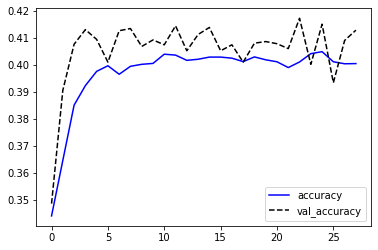

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.legend()
plt.show()

In [12]:
env.close()
env = gym.make('MountainCar-v0')
scores = []
steps = []
actions = []

for i in range(500):
  score = 0
  step = 0
  previous_obs = []
  env.reset()

  while True:
    if len(previous_obs) == 0:
      action = env.action_space.sample()
      print('start! : ', i)
    else:
      logit = model.predict(np.expand_dims(previous_obs, axis=0))[0]
      action = np.argmax(logit)
      actions.append(action)
    obs, reward, done, _ = env.step(action)
    previous_obs = obs
    score += reward
    step += 1

    if done:
      break

  scores.append(score)
  steps.append(step)

print('finished!')

start! :  0
start! :  1
start! :  2
start! :  3
start! :  4
start! :  5
start! :  6
start! :  7
start! :  8
start! :  9
start! :  10
start! :  11
start! :  12
start! :  13
start! :  14
start! :  15
start! :  16
start! :  17
start! :  18
start! :  19
start! :  20
start! :  21
start! :  22
start! :  23
start! :  24
start! :  25
start! :  26
start! :  27
start! :  28
start! :  29
start! :  30
start! :  31
start! :  32
start! :  33
start! :  34
start! :  35
start! :  36
start! :  37
start! :  38
start! :  39
start! :  40
start! :  41
start! :  42
start! :  43
start! :  44
start! :  45
start! :  46
start! :  47
start! :  48
start! :  49
start! :  50
start! :  51
start! :  52
start! :  53
start! :  54
start! :  55
start! :  56
start! :  57
start! :  58
start! :  59
start! :  60
start! :  61
start! :  62
start! :  63
start! :  64
start! :  65
start! :  66
start! :  67
start! :  68
start! :  69
start! :  70
start! :  71
start! :  72
start! :  73
start! :  74
start! :  75
start! :  76
start! : 

In [0]:
print('mean of scores', np.mean(scores))
print('mean of steps', np.mean(steps))

mean of scores -138.194
mean of steps 138.194


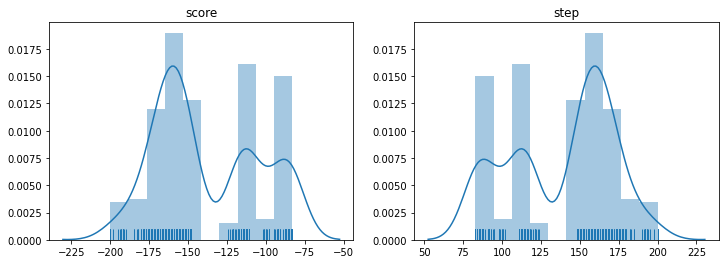

In [0]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('score')
ax[1].set_title('step')
sns.distplot(scores, rug=True, ax=ax[0])
sns.distplot(steps, rug=True, ax=ax[1])

In [11]:
env.close()
env = wrap_env(gym.make('MountainCar-v0'))
env.reset()

score = 0
step = 0
previous_obs = []
while True:
  if len(previous_obs) == 0:
    action = env.action_space.sample()
  else:
    logit = model.predict(np.expand_dims(previous_obs, axis=0))[0]
    action = np.argmax(logit)
  obs, reward, done, _ = env.step(action)
  previous_obs = obs
  score += reward
  step += 1

  if done:
    break
  
print('score : ', score)
print('step : ', step)
env.close()
show_video()

score :  -92.0
step :  92
